In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
print("Success") 

Success


# 1 Intro
Load the mpg dataset. Read the documentation for it, and use the data to answer these questions:



In [2]:
# create a Data Frame of the mpg data from the imported data
mpg = pd.DataFrame(data('mpg'))

In [3]:
# On average, which manufacturer has the best miles per gallon?

# First create a new column in the dataframe that gets the avg MPG between highway and city for each car
mpg['avg_miles_per_gallon'] = (mpg['hwy'] + mpg['cty'])/2

# Then use the group by function combined with the mean and tail function to get which manufacturer has the highest avg MPG
mpg.groupby(['manufacturer'])['avg_miles_per_gallon'].mean().sort_values().tail(1)

manufacturer
honda    28.5
Name: avg_miles_per_gallon, dtype: float64

In [4]:
# How many different models are there?

mpg['model'].nunique()

38

In [5]:
# Do automatic or manual cars have better miles per gallon?
def trans_type(trans):
    if 'auto' in trans:
        return 'auto'
    else:
        return 'manual'



mpg['trans_type'] = mpg['trans'].apply(trans_type)
mpg.groupby('trans_type').avg_miles_per_gallon.mean()

trans_type
auto      19.130573
manual    22.227273
Name: avg_miles_per_gallon, dtype: float64

# 2 Joining
Copy the users and roles dataframes from the examples above. What do you think a right join would look like? An outer join? What happens if you drop the foreign keys from the dataframes and try to merge them?



In [6]:
# Roles
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})

# Users
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})

In [7]:
# Right join - will show the all the column from the role's df and only matching ones from the users table

pd.merge(users, roles, left_on='role_id', right_on='id', how='right')

,id_x,name_x,role_id,id_y,name_y
0,1.0,bob,1.0,1,admin
1,2.0,joe,2.0,2,author
2,3.0,sally,3.0,3,reviewer
3,4.0,adam,3.0,3,reviewer
4,NaN,NaN,NaN,4,commenter


In [8]:
# Outer join - Will show all rows and columns from both data frames even the ones that aren't paried

pd.merge(users, roles, left_on='role_id', right_on='id', how='outer')

,id_x,name_x,role_id,id_y,name_y
0,1.0,bob,1.0,1.0,admin
1,2.0,joe,2.0,2.0,author
2,3.0,sally,3.0,3.0,reviewer
3,4.0,adam,3.0,3.0,reviewer
4,5.0,jane,NaN,NaN,NaN
5,6.0,mike,NaN,NaN,NaN
6,NaN,NaN,NaN,4.0,commenter


In [9]:
# Outer join - Will show all rows and columns from both data frames even the ones that aren't 

pd.merge(users, roles, left_on='role_id', right_on='id', how='right')


,id_x,name_x,role_id,id_y,name_y
0,1.0,bob,1.0,1,admin
1,2.0,joe,2.0,2,author
2,3.0,sally,3.0,3,reviewer
3,4.0,adam,3.0,3,reviewer
4,NaN,NaN,NaN,4,commenter


In [10]:
# What happens if you drop the foreign keys from the dataframes and try to merge them? 
# Answer - it doesn't know how to stitch the dfs together and will only return the left or right df; however...
# an outer join will work like a concatenate
 

roles2 = roles.drop(columns = ['id'])
users2 = users.drop(columns = ['role_id'])

pd.merge(users2, roles2, how='outer')


,id,name
0,1.0,bob
1,2.0,joe
2,3.0,sally
3,4.0,adam
4,5.0,jane
5,6.0,mike
6,NaN,admin
7,NaN,author
8,NaN,reviewer
9,NaN,commenter


# 3 Getting data from SQL databases



In [11]:
from env import host, user, password

get_db_url = f'mysql+pymysql://{user}:{password}@{host}/employees'
    
df = pd.read_sql("""SELECT * FROM employees LIMIT 5 OFFSET 50""", get_db_url)
df

,emp_no,birth_date,first_name,last_name,gender,hire_date
0,10051,1953-07-28,Hidefumi,Caine,M,1992-10-15
1,10052,1961-02-26,Heping,Nitsch,M,1988-05-21
2,10053,1954-09-13,Sanjiv,Zschoche,F,1986-02-04
3,10054,1957-04-04,Mayumi,Schueller,M,1995-03-13
4,10055,1956-06-06,Georgy,Dredge,M,1992-04-27


In [12]:
dfbroken = pd.read_sql("""SELECT * FRM employees LIMIT 5 OFFSET 50""", get_db_url)

ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'FRM employees LIMIT 5 OFFSET 50' at line 1")
[SQL: SELECT * FRM employees LIMIT 5 OFFSET 50]
(Background on this error at: http://sqlalche.me/e/f405)

In [13]:
# Read the employees and titles tables into two separate dataframes

titles = pd.read_sql("""SELECT * FROM titles""", get_db_url)
employees = pd.read_sql("""SELECT * FROM employees""", get_db_url)



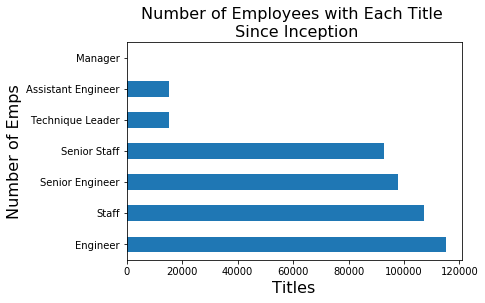

In [14]:
# Visualize the number of employees with each title.
num_emp_per_title = titles.groupby('title')['emp_no'].count().sort_values(ascending=False)

num_emp_per_title.plot.barh()
plt.title("Number of Employees with Each Title \n Since Inception", fontsize=16)
plt.xlabel("Titles", fontsize=16)
plt.ylabel("Number of Emps", fontsize=16)
plt.show()

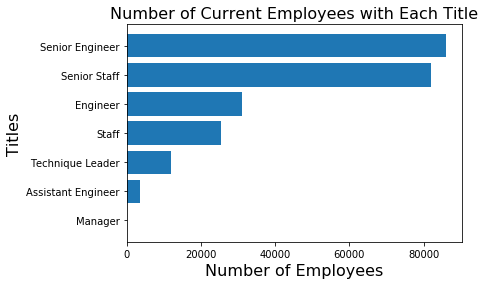

In [15]:
# Group by both to_date and title to get a count of titles for each position by date each employee had that position
title_count = titles.groupby(['to_date', 'title']).count()

#Reindex the the data frame to break the groupings
title_count = title_count.reset_index()

# Change to_date to a string to be able to access it's data
title_count['to_date'] = title_count["to_date"].astype(str)

# pull the title and emp_no (which is a count of employees for each title) where the to_date is current (9999-01-01)
# and sort by emp_no 
title_count = title_count[['title', 'emp_no']][title_count['to_date'] == '9999-01-01'].sort_values(by = ['emp_no'])

# Plot the results
plt.barh(title_count['title'], title_count['emp_no'])
plt.title("Number of Current Employees with Each Title", fontsize=16)
plt.xlabel("Number of Employees", fontsize=16)
plt.ylabel("Titles", fontsize=16)
plt.show()

In [16]:
# Join the employees and titles dataframes together.

# Conduct a left join of the titles table on the employees table
full_table = pd.merge(employees, titles, left_on='emp_no', right_on='emp_no', how='left')
full_table.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,Senior Engineer,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,Staff,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,Senior Engineer,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Engineer,1986-12-01,1995-12-01
4,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Senior Engineer,1995-12-01,9999-01-01


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

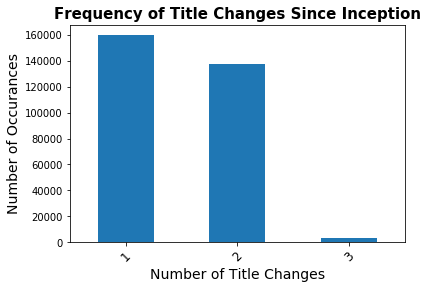

In [17]:
# Visualize how frequently employees change titles.

# Create a series to plot where the series is grouped by emp_no, it counts the number of titles for each emp, and...
# then counts the number of occurances of each number of title
number_of_title_changes = full_table.groupby('emp_no')['title'].count().value_counts()


# Plot the results
number_of_title_changes.plot.bar()
plt.title('Frequency of Title Changes Since Inception', fontsize=15, fontweight='bold')
plt.xlabel('Number of Title Changes', fontsize=14)
plt.ylabel('Number of Occurances', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

In [18]:
# For each title, find the hire date of the employee that was hired most recently with that title.

# If question is asking for the most recent hire that had a particular title
full_table[['hire_date']].groupby(full_table['title']).max()

,hire_date
title,
Assistant Engineer,1999-12-24
Engineer,2000-01-28
Manager,1992-02-05
Senior Engineer,2000-01-01
Senior Staff,2000-01-13
Staff,2000-01-12
Technique Leader,1999-12-31


In [19]:
# If the question is asking for the most recent hire with each title currently

# Transform to_date to a string 
full_table['to_date'] = full_table["to_date"].astype(str)

# use the loc function to find all rows where the column to_date is equal to '9999-01-01'...
# then group by the title and find the max hire date for each title
full_table.loc[full_table['to_date'] == '9999-01-01'].groupby('title')[['hire_date']].max()

,hire_date
title,
Assistant Engineer,1999-12-24
Engineer,2000-01-23
Manager,1992-02-05
Senior Engineer,2000-01-01
Senior Staff,2000-01-13
Staff,2000-01-12
Technique Leader,1999-12-15


In [21]:
# Write the code necessary to create a cross tabulation of the number of titles by department. 
# (Hint: this will involve a combination of SQL and python/pandas code)

title_by_department = pd.read_sql("""select dept_name, title from departments
join dept_emp
using (dept_no)
join titles
using (emp_no)
where titles.to_date > curdate()
and dept_emp.to_date > curdate()""", get_db_url)

title_by_department

pd.crosstab(title_by_department.dept_name, title_by_department.title)


title,Assistant Engineer,Engineer,Manager,Senior Engineer,Senior Staff,Staff,Technique Leader
dept_name,,,,,,,
Customer Service,68,627,1,1790,11268,3574,241
Development,1652,14040,1,38816,1085,315,5477
Finance,0,0,1,0,9545,2891,0
Human Resources,0,0,1,0,9824,3073,0
Marketing,0,0,1,0,11290,3551,0
Production,1402,12081,1,33625,1123,349,4723
Quality Management,389,3405,1,9458,0,0,1293
Research,77,830,1,2250,9092,2870,321
Sales,0,0,1,0,28797,8903,0


# 4 Use your get_db_url function to help you explore the data from the chipotle database. Use the data to answer the following questions:

In [36]:
# import the data

get_db_url2 = f'mysql+pymysql://{user}:{password}@{host}/chipotle'
    
chipotle = pd.read_sql("""SELECT * FROM orders""", get_db_url2)
chipotle.head()

,id,order_id,quantity,item_name,choice_description,item_price
0,1,1,1,Chips and Fresh Tomato Salsa,nan,$2.39
1,2,1,1,Izze,[Clementine],$3.39
2,3,1,1,Nantucket Nectar,[Apple],$3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,$2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",$16.98


In [38]:
# What is the total price for each order?

# Clean the item price data by removing the $ and converting it into a float
chipotle['item_price'] = chipotle['item_price'].str.replace('$', "")
chipotle['item_price'] = chipotle.item_price.astype(float)

# create a new column called order_total where the order_total is equal to the quanity * item_price
chipotle['order_total'] = (chipotle['quantity'] * chipotle['item_price'])
chipotle

,id,order_id,quantity,item_name,choice_description,item_price,order_total
0,1,1,1,Chips and Fresh Tomato Salsa,nan,2.39,2.39
1,2,1,1,Izze,[Clementine],3.39,3.39
2,3,1,1,Nantucket Nectar,[Apple],3.39,3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,2.39,2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",16.98,33.96
...,...,...,...,...,...,...,...
4617,4618,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Black Beans, Sour Cream, Cheese, Lettuce, Guacamole]]",11.75,11.75
4618,4619,1833,1,Steak Burrito,"[Fresh Tomato Salsa, [Rice, Sour Cream, Cheese, Lettuce, Guacamole]]",11.75,11.75
4619,4620,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Pinto Beans, Guacamole, Lettuce]]",11.25,11.25
4620,4621,1834,1,Chicken Salad Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Lettuce]]",8.75,8.75


In [44]:
# What are the most popular 3 items?
chipotle.groupby('item_name')[['quantity']].sum().sort_values('quantity', ascending=False).head(3)

,quantity
item_name,
Chicken Bowl,761
Chicken Burrito,591
Chips and Guacamole,506


In [46]:
Which item has produced the most revenue?

chipotle.groupby('item_name')[['order_total']].sum().sort_values('order_total', ascending=False).head(1)

Object `revenue` not found.


,order_total
item_name,
Chicken Bowl,8044.63
